# Simhash 

## How it works

The unique and most interesting characteristic of the Simhash algorithm is that near duplicate documents will most likely have the same (or pretty similar) hash value. This feature makes it very useful when it comes to near duplicate document detection since it **doesn’t require to compare all the documents with each other**. That comparison would result to a O(n^2) complexity. By using simhash we no longer need a pair-wise comparison between all the documents. We only need a single pass over our collection. After calculating the hash values for all the documents we just need to compare the ones that share the same (or similar) hash values which results in an O(n) complexity.

In order to calculate the simhash value of a document we perform the following steps:

- Split the document in tokens (words, characters or n-grams)
- Hash each token separately using MD5
- Calculate the bit representation of this MD5 hashes
- Calculate and apply a weight to each of the document’s tokens. In our case this weights are the term frequencies in the document.
- Merge the bit representations of all the tokens of the document in order to calculate the document’s final hash value.

**Because of python version mistakes in simhash libraries I copied Simhash file from repo to here for correction**

In [5]:
!git clone https://github.com/memosstilvi/simhash.git

Cloning into 'simhash'...


In [55]:
data = {
    1: 'Im testing simhash algorithm.',
    2: 'test of simhash algorithm',
    3: 'This is simhash test.',
}

In [67]:
# assuming that you have a dictionary with document id as the key and the document as the value: 
# documents = { doc_id: doc } you can do:

#from simhash import simhash

def split_hash(str, num):
    return [ str[start:start+num] for start in range(0, len(str), num) ]

hashes = {}
#line.encode('utf-8')
for doc_id, doc in data.items():
    hash = simhash(doc)

    # you can either use the whole hash for higher precision or split into chunks for higher recall
    hash_chunks = split_hash(hash, 4)

    for chunk in hash_chunks:
        if chunk not in hashes:
            hashes[chunk] = []
        hashes[chunk].append(doc_id)

# now you can print the duplicate documents:
for doc_list in hashes:
    if int(doc_list) > 1:
        print("Duplicates documents: ", doc_list)
print(hashes)

Duplicates documents:  0010
Duplicates documents:  0100
Duplicates documents:  1011
Duplicates documents:  1010
Duplicates documents:  0111
Duplicates documents:  1110
Duplicates documents:  0101
Duplicates documents:  1001
Duplicates documents:  0011
Duplicates documents:  1100
Duplicates documents:  1101
Duplicates documents:  1000
Duplicates documents:  0110
{'0010': [1, 1, 1, 2, 3, 3, 3, 3, 3, 3], '0100': [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3], '1011': [1], '1010': [1, 1, 1, 2, 2, 3, 3], '0111': [1, 3], '1110': [1, 1, 1, 2, 3], '0101': [1, 2, 2], '0001': [1, 2, 3], '1001': [1, 1, 2, 3], '0000': [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3], '0011': [1, 1, 1, 2, 3], '1100': [1, 1, 2, 2, 2, 3], '1101': [1], '1000': [1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3], '0110': [2, 2, 2, 3, 3]}


## Simhash Corrected code from Repo
repo file has some older version bugs replaced 
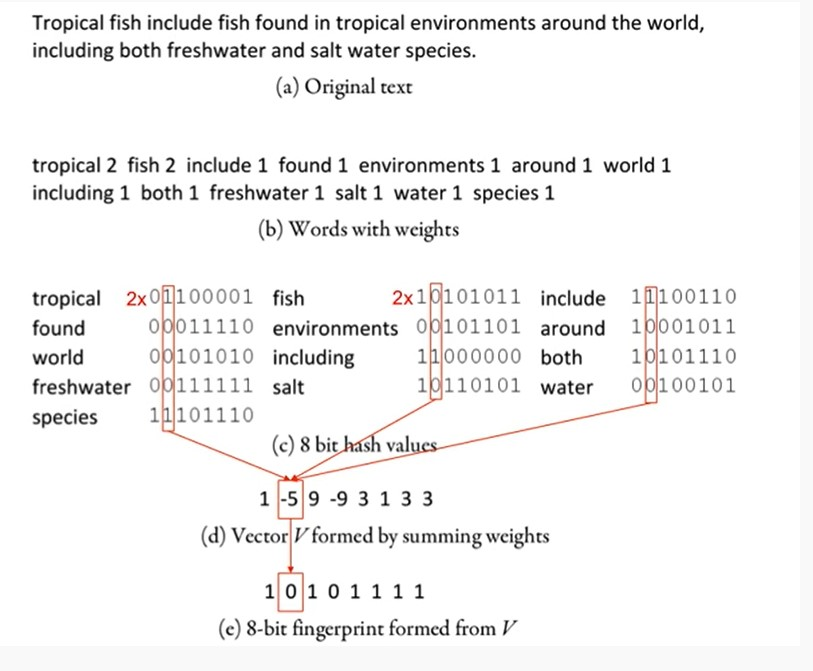

In [66]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import re
from hashlib import md5
import sys

class Token:

    def __init__(self, hash_list, weight):
        self.hash_list = hash_list
        self.weight = weight

def tokenize(doc):
    """
    Lower case, remove punctuation and split in spaces
    """
    #doc = doc.lower()
    doc = re.sub('[,;]', ' ', str(doc))
    doc = re.split('\s+', doc)
    doc = filter(None, doc)
    return doc

def md5Hash(token):
    h = bin(int(md5(token.encode('utf-8')).hexdigest(), 16))
    return h[2:]

def hash_threshold(token_dict, fp_len):
    """
    Iterate through the token dictionary multiply the hash lists with the weights
    and apply the binary threshold
    """
    sum_hash = [0] * fp_len
    for _, token in token_dict.items():
        sum_hash = [ x + token.weight * y for x, y in zip(sum_hash, token.hash_list)]

    # apply binary threshold
    for i, ft in enumerate(sum_hash):
        if ft > 0:
            sum_hash[i] = 1
        else:
            sum_hash[i] = 0
    return sum_hash

def binconv(fp, fp_len):
    """
    Converts 0 to -1 in the tokens' hashes to facilitate
    merging of the tokens' hashes later on.
    input  : 1001...1
    output : [1,-1,-1, 1, ... , 1]
    """
    vec = [1] * fp_len
    for indx, b in enumerate(fp):
        if b == '0':
            vec[indx] = -1
    return vec


def calc_weights(terms, fp_len):
    """
    Calculates the weight of each one of the tokens. In this implementation
    these weights are equal to the term frequency within the document.

    :param tokens: A list of all the tokens (words) within the document
    :fp_len: The length of the Simhash values
    return dictionary "my_term": Token([-1,1,-1,1,..,-1], 5)
    """
    term_dict = {}
    for term in terms:
        # get weights
        if term not in term_dict:
            fp_hash = md5Hash(term).zfill(fp_len)
            fp_hash_list = binconv(fp_hash, fp_len)
            token = Token(fp_hash_list, 0)
            term_dict[term] = token
        term_dict[term].weight += 1
    return term_dict

def simhash(doc, fp_len=128):
    """
    :param doc: The document we want to generate the Simhash value
    :fp_len: The number of bits we want our hash to be consisted of.
                Since we are hashing each token of the document using
                md5 (which produces a 128 bit hash value) then this
                variable fp_len should be 128. Feel free to change
                this value if you use a different hash function for
                your tokens.
    :return The Simhash value of a document ex. '0000100001110'
    """
    tokens = tokenize(doc)
    token_dict = calc_weights(tokens, fp_len)
    fp_hash_list = hash_threshold(token_dict, fp_len)
    fp_hast_str =  ''.join(str(v) for v in fp_hash_list)
    return fp_hast_str


if __name__ == '__main__':
    # Just for demonstration
    doc = data #data
    binary_hash = simhash(doc)
    print(binary_hash)

10101111111010100110110110111000110010001001100000100000011100111100010000100000110010100011011010000001100111010110110110100110


## Reference:
- https://github.com/memosstilvi/simhash/blob/master/simhash.py
- http://benwhitmore.altervista.org/simhash-and-solving-the-hamming-distance-problem-explained/?doing_wp_cron=1648459015.2995688915252685546875
- Important Video -> https://www.youtube.com/watch?v=gnraT4N43qo